# 2. Machine learning models

Now, we will build ML models to predict conversion rates based on user profiles. Our goal is to make accurate predictions and gain insights on how to improve user conversions. 

We choose the following models: 
1. Logistic regression
2. Random forest
3. XGBoost 

In [38]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import time
sns.set_theme()

Fontsize=12

## 2.1. Data preprocessing 

**Dummy encoding for categorical features**:

We create dummy variables for the categorical features (country and source)

In [39]:
df = pd.read_csv('conversion_data_clean.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [40]:
df_dummy = pd.get_dummies(df,drop_first=True)

In [41]:
df_dummy.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


In [42]:
X= df_dummy.drop(['converted'],axis=1)
Y = df_dummy['converted']

**Split data into train/test sets and treating imbalanced data with SMOTE**:


Note:SMOTE (Sythetic Minority Oversampling Technique) is an oversampling method where sythetic samples of the minority class are created by slightly modifying the sample attributes proportional to the difference in neighboring instances. Here we treat the data by oversampling the converted class with SMOTE.


In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=1)
print(f'The shape of X_train is {X_train.shape}')
print(f'The shape of X_test is {X_test.shape}')
print(f'The shape of y_train is {y_train.shape}')
print(f'The shape of y_test is {y_test.shape}')


The shape of X_train is (221338, 8)
The shape of X_test is (94860, 8)
The shape of y_train is (221338,)
The shape of y_test is (94860,)


In [44]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# import SMOTE module from imblearn library
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 1000)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())
  
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 7137
Before OverSampling, counts of label '0': 214201 

After OverSampling, the shape of X_train: (428402, 8)
After OverSampling, the shape of y_train: (428402,) 

After OverSampling, counts of label '1': 214201
After OverSampling, counts of label '0': 214201


## 2.2. Logistic regression

In [45]:
from sklearn.linear_model import LogisticRegression

### 2.2.1. Hyperparameter tuning 
We determine the regularization method and penalty paremeter C for the logistic model using cross-validated grid search. Since we care more about converted users, we want to accurately predict the converted user group and minimize false nagetive errors where converted users are predicted to not convert. Thus, we use "recall" as our scoring in cross-validation. 

The optimal parameters are found to be:
- regularization method = L2 
- penalty parameter C = 0.01

In [55]:
from sklearn.model_selection import GridSearchCV
penalty = ['l1','l2']
C = [0.001,0.01,0.1,1,10,100,1000]
t=time.time()
# grid={"penalty":penalty,"C":C}
grid = {"C":C,"penalty":penalty}
logreg=LogisticRegression(solver='liblinear')
model=GridSearchCV(logreg,grid,cv=5,scoring='recall',return_train_score=True)
model.fit(X_train_res,y_train_res)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 77.78891015052795 seconds.


In [56]:
best_params_lr = model.best_params_
print(best_params_lr)

{'C': 0.01, 'penalty': 'l2'}


In [57]:
train_f1 = model.cv_results_['mean_train_score'].reshape(len(C),len(penalty))
cv_f1 = model.cv_results_['mean_test_score'].reshape(len(C),len(penalty))

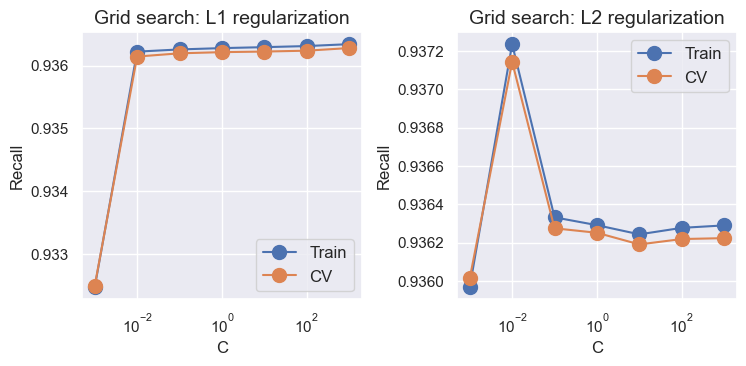

In [58]:
fig, axes = plt.subplots(1,2,figsize= (8,4))
plt.tight_layout(pad=3)
titles = [train_f1,cv_f1]
for i in range(len(penalty)):
    scores_train = train_f1[:,i]
    scores_cv = cv_f1[:,i]

    axes[i].semilogx(C,scores_train,'-o',markersize=10,label='Train')
    # axes[i].set_title('Grid search train: L1 regularization')
    axes[i].semilogx(C,scores_cv,'-o',markersize=10,label='CV')
    # axes[i].set_title('Grid search CV: L1 regularization')
    axes[i].legend(fontsize=Fontsize)
    axes[i].set_xlabel('C',fontsize=Fontsize)
    axes[i].set_ylabel('Recall',fontsize=Fontsize)
    axes[i].set_title(f"Grid search: {'L1 regularization' if i==0 else 'L2 regularization'}",fontsize=Fontsize+2)
    # axes[i].set_xlabel("number of estimators")
    # axes[i].set_ylabel("maximum depth")
plt.show()

## 2.2.2. Logistic regression with optimal parameters 

For the "converted" class, the recall is 0.93. 

In [59]:
model_lr_opt = LogisticRegression(**best_params_lr)
model_lr_opt.fit(X_train_res, y_train_res.ravel())

y_pred_lr= model_lr_opt.predict(X_test)

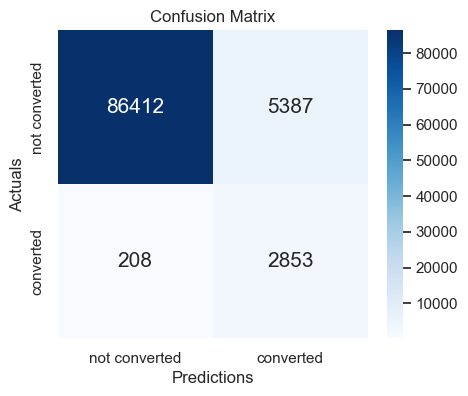

In [60]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_lr)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(conf_matrix,xticklabels=['not converted','converted'],
            yticklabels=['not converted','converted'],annot=True,
            fmt="g", annot_kws={"size": 15},cmap="Blues",ax=ax)
ax.set_xlabel('Predictions', fontsize=Fontsize)
ax.set_ylabel('Actuals', fontsize=Fontsize)
plt.title('Confusion Matrix', fontsize=Fontsize)
plt.show()

In [62]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
print('Classification report:')
print(classification_report(y_test, y_pred_lr))


recall_lr = recall_score(y_test, y_pred_lr)
print(f"The recall socre is {recall_lr}")

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     91799
           1       0.35      0.93      0.50      3061

    accuracy                           0.94     94860
   macro avg       0.67      0.94      0.74     94860
weighted avg       0.98      0.94      0.95     94860

The recall socre is 0.9320483502123489


### 2.2.3. Feature importance

Here, we want to understand what types of users are mostly likely to convert. We measure the feature importance by the weights provided by the logistic regression model.


From the table and barplot below, we find that **older users are more likely to convert than new user.** Also, **users from UK and US are more likely to convert.** 

In [63]:
feature_names = list(X_train_res.columns)

feature_coefs = model_lr_opt.coef_[0]
df_features = pd.DataFrame(feature_coefs,columns=['weight'],index=feature_names)
df_features['|weight|'] = abs(feature_coefs)
df_features= df_features.sort_values(by='|weight|',ascending=False)
# df_important_features=df_important_features.rename({'country_int':'country','source_int':'source'})
df_features

,weight,|weight|
new_user,-2.215793,2.215793
country_UK,1.080139,1.080139
country_US,0.967596,0.967596
source_Direct,-0.941816,0.941816
total_pages_visited,0.741084,0.741084
country_Germany,0.666308,0.666308
source_Seo,-0.527187,0.527187
age,-0.075991,0.075991


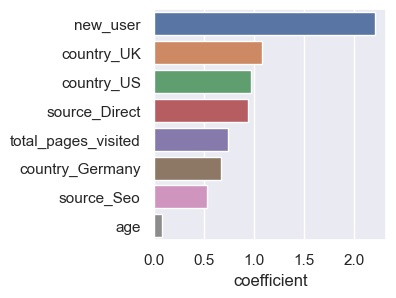

In [64]:
fig, ax= plt.subplots(figsize=(3,3))
sns.barplot(data=df_features, y=df_features.index, x="|weight|", 
            orient='h',ax=ax)
# ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('coefficient')
plt.show()

## 2.3. Random forest 

In [65]:
from sklearn.ensemble import RandomForestClassifier

### 2.3.1. Hyperparameter tuning 
We determine the optimal number of estimators and maximum tree depth for the random forest using cross-validated grid search. 
The optimal parameters are found to be:
- number of estimators = 25
- maximum depth = 50

In [66]:
from sklearn.model_selection import GridSearchCV

t= time.time()
clf = RandomForestClassifier(n_jobs=-1)
number_of_estimators = [5, 10, 50, 100, 120]
max_depth =[1, 5, 7, 10, 15, 25, 30]
parameters = {'n_estimators': number_of_estimators ,'max_depth':max_depth}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='recall',return_train_score=True)
model.fit(X_train_res,y_train_res)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 426.6209101676941 seconds.


In [67]:
best_params_rf = model.best_params_
print(best_params_rf)

{'max_depth': 25, 'n_estimators': 120}


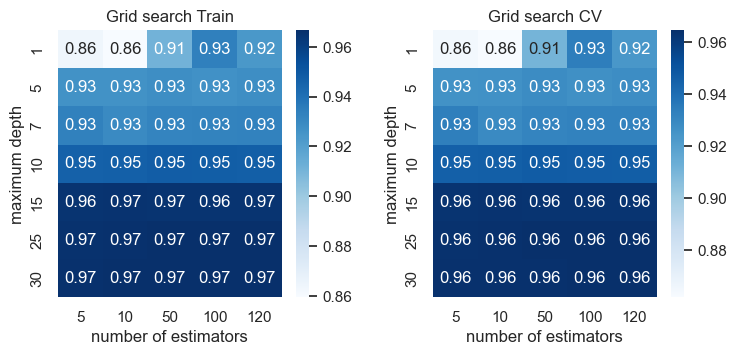

In [68]:
train_f1 = model.cv_results_['mean_train_score'].reshape(len(max_depth),len(number_of_estimators))
cv_f1 = model.cv_results_['mean_test_score'].reshape(len(max_depth),len(number_of_estimators))


fig, axes = plt.subplots(1,2,figsize= (8,4))
plt.tight_layout(pad=3)
titles = [train_f1,cv_f1]
for i in range(2):
    sns.heatmap(titles[i],xticklabels=number_of_estimators,yticklabels=max_depth,
                annot=True,cmap='Blues',ax=axes[i])
    axes[i].set_title(f"Grid search {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("number of estimators")
    axes[i].set_ylabel("maximum depth")
plt.show()

### 2.3.2. Random forest with optimal parameters
Now we train our model with the optimal parameters. The recall for the converted class is 0.85. 

In [69]:
model_rf_opt = RandomForestClassifier(**best_params_rf)
model_rf_opt.fit(X_train_res,y_train_res)
y_pred_rf = model_rf_opt.predict(X_test)

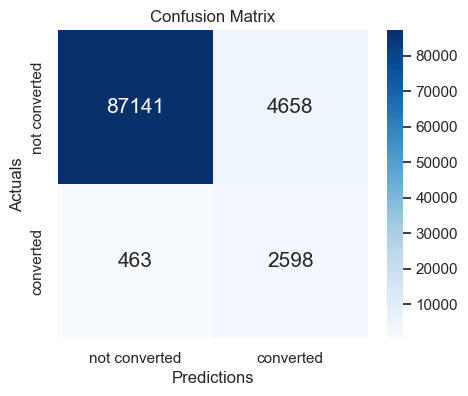

In [223]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(conf_matrix,xticklabels=['not converted','converted'],
            yticklabels=['not converted','converted'],annot=True,
            fmt="g", annot_kws={"size": 15},cmap="Blues",ax=ax)
ax.set_xlabel('Predictions', fontsize=Fontsize)
ax.set_ylabel('Actuals', fontsize=Fontsize)
plt.title('Confusion Matrix', fontsize=Fontsize)
plt.show()

In [224]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
print('Classification report:')
print(classification_report(y_test, y_pred_rf))

recall_rf = recall_score(y_test, y_pred_rf)
print(f"The recall socre is {recall_rf}")

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     91799
           1       0.36      0.85      0.50      3061

    accuracy                           0.95     94860
   macro avg       0.68      0.90      0.74     94860
weighted avg       0.97      0.95      0.96     94860

The recall socre is 0.8487422410976805


### 2.3.3. Feature importance
We would like to know how much each featrue contributes to user conversions. 


From the data frame and barplot below, we see that **the most important feature to user conversions is the total number of pages users have visited** by a large margin, which is logical since the nubmer of pages a user visits should be proportional to their interest in the site and its products. The second important feature is weather the user is new or returning. **Returning users are more likely to make purchases** so the marketing team should prioritize existing users with accounts. 


**The least important feature is the marketing channel source.** 



In [225]:
feature_importance = model_rf_opt.feature_importances_
df_features = pd.DataFrame(feature_importance,columns=['importance'],index=feature_names)
df_important_features= df_features.sort_values(by='importance',ascending=False)
df_important_features=df_important_features.rename({'country_int':'country','source_int':'source'})
df_important_features

,importance
total_pages_visited,0.733977
new_user,0.146107
age,0.084595
country_US,0.011141
country_UK,0.009181
source_Direct,0.006705
source_Seo,0.004581
country_Germany,0.003712


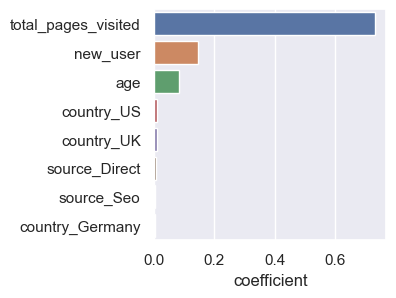

In [226]:
fig, ax= plt.subplots(figsize=(3,3))
sns.barplot(data=df_important_features, y=df_important_features.index, x="importance", 
            orient='h',ax=ax)
# ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('coefficient')
plt.show()

In [229]:
X_train_res_no_total_pages  =X_train_res.drop(columns='total_pages_visited')
X_test_no_total_pages  =X_test.drop(columns='total_pages_visited')

model_rf_opt_2 = RandomForestClassifier(**best_params_rf)
model_rf_opt_2.fit(X_train_res_no_total_pages,y_train_res)
y_pred_rf_2 = model_rf_opt_2.predict(X_test_no_total_pages)

In [232]:
feature_names_2 = feature_names.remove('total_pages_visited')

In [235]:
feature_importance_2 = model_rf_opt_2.feature_importances_
df_features_2 = pd.DataFrame(feature_importance_2,columns=['importance'],index=feature_names)
df_important_features_2= df_features_2.sort_values(by='importance',ascending=False)
df_important_features_2=df_important_features_2.rename({'country_int':'country','source_int':'source'})
df_important_features_2 


,importance
new_user,0.613080
age,0.199542
country_UK,0.058530
country_US,0.058380
source_Direct,0.029007
country_Germany,0.025423
source_Seo,0.016038


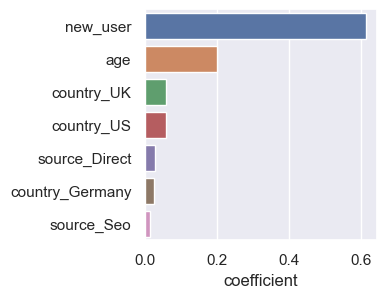

In [237]:
fig, ax= plt.subplots(figsize=(3,3))
sns.barplot(data=df_important_features_2, y=df_important_features_2.index, x="importance", 
            orient='h',ax=ax)
# ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('coefficient')
plt.show()

## 2.4. Decision tree

Here, we build a decision tree model to visualize our results.

In [305]:
from sklearn import tree

model_dt = tree.DecisionTreeClassifier(max_depth=3,class_weight={0: 0.5, 1: 0.5})
model_dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight={0: 0.5, 1: 0.5}, max_depth=3)

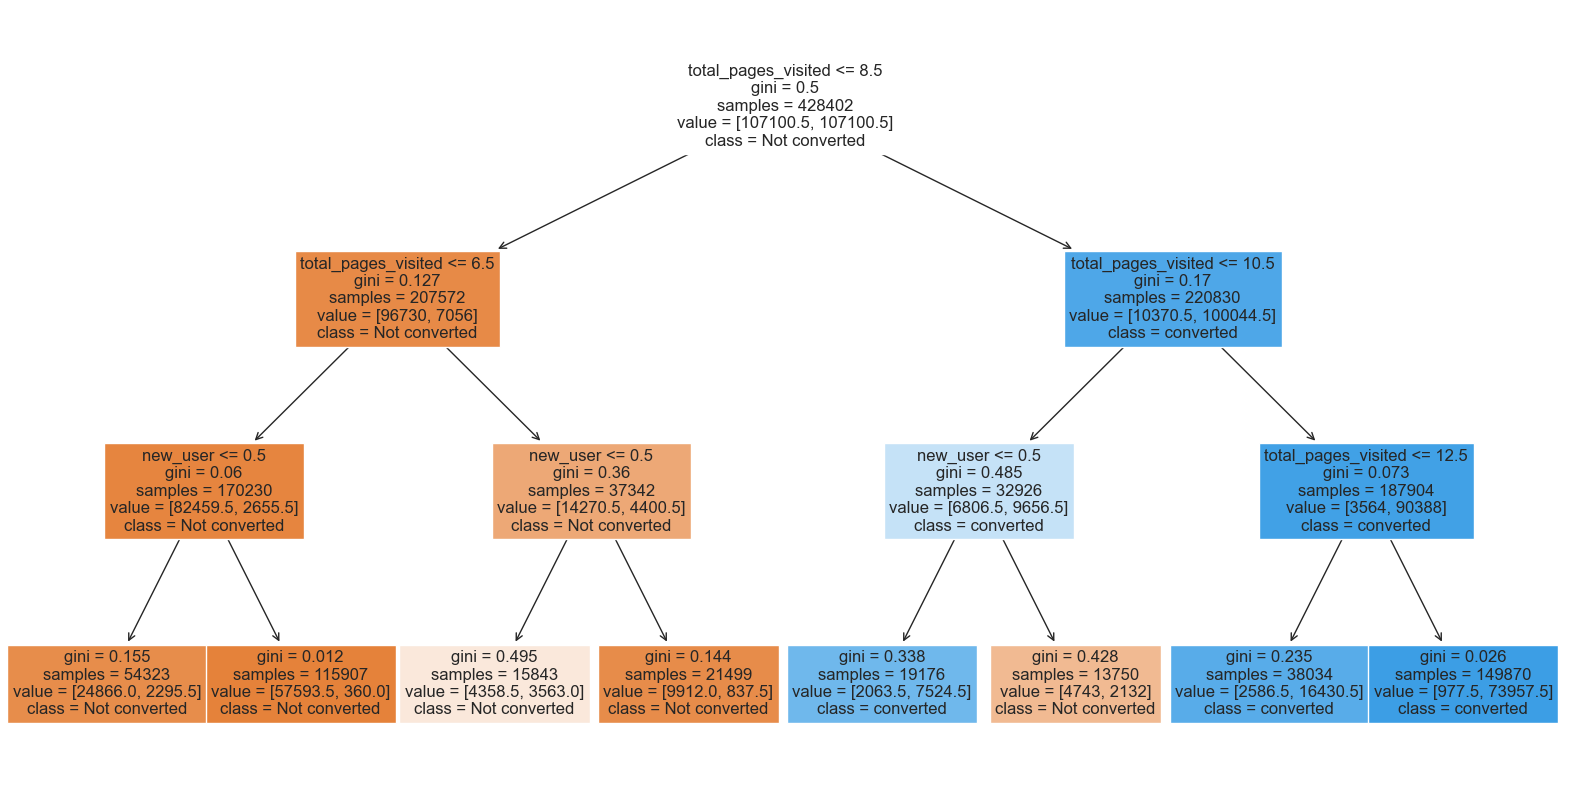

In [306]:
features = list(X_train_res.columns)
targets = ['Not converted', 'converted']

plt.figure(figsize=(20,10))
tree.plot_tree(model_dt,feature_names=features,
          class_names=targets,
          filled=True,fontsize=12)
plt.show()

## 2.6 XGBoost

Different from the random forest model, XGBoost is a boosting method that uses gradient boosting on weak decision tree leaners. Since boosting algorithms tend to be more accurate compared to bagging algorithms, XGBoost generally produces more accurate predictions than random forest models. XGBoost is also equipped with built-in regularizations and, therefore, is less likely to overfit compared to other boosting methods.

If the purpose of the model is to make accurate predictions on which users will convert, then XGBoost is prefered over random forest models. If the purpose of the model is to identify important features to user conversions and prediction accuracy is not required, then random forest is perferable since it's less likely to overfit and is computationally cheaper.

In [86]:
import joblib
from xgboost import XGBClassifier

### 2.6.1. Hyperparameter tuning 
We determine the optimal number of estimators and maximum tree depth for the XGBoost model. 

The optimal parameters are found to be:
- number of estimators = 5
- maximum depth = 120

In [139]:
from sklearn.model_selection import GridSearchCV

t= time.time()
clf = XGBClassifier(n_jobs= -1,max_depth= 5)
number_of_estimators = [5, 10, 50, 100, 120]
# max_depth =[1, 5, 7, 10, 15, 25, 30]
learning_rates = [0.01, 0.05,0.1,0.3]
parameters = {'n_estimators': number_of_estimators, 'eta':learning_rates}
model = GridSearchCV(estimator=clf, param_grid=parameters, cv=5, n_jobs=-1, scoring='recall',return_train_score=True)
model.fit(X_train_res,y_train_res)

Elapsed = time.time()-t
print(f"The elapsed time is {Elapsed} seconds.")

The elapsed time is 188.31440114974976 seconds.


In [149]:
best_params_xgb = model.best_params_
print(best_params_xgb)

{'eta': 0.3, 'n_estimators': 120}


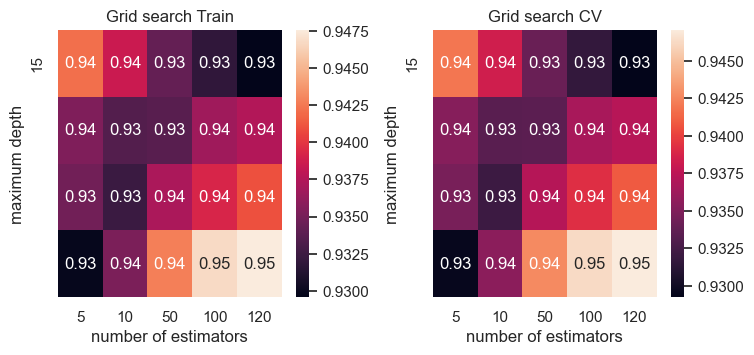

In [148]:
train_f1 = model.cv_results_['mean_train_score'].reshape(4,5)
cv_f1 = model.cv_results_['mean_test_score'].reshape(4,5)


fig, axes = plt.subplots(1,2,figsize= (8,4))
plt.tight_layout(pad=3)
titles = [train_f1,cv_f1]
for i in range(2):
    sns.heatmap(titles[i],xticklabels=number_of_estimators,yticklabels=max_depth,annot=True,ax=axes[i])
    axes[i].set_title(f"Grid search {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("number of estimators")
    axes[i].set_ylabel("maximum depth")
plt.show()

## 2.5.2. XGBoost with optimal parameters
Now we train our model with the optimal parameters. The recall for the predictions is 0.91, which is higher than the random forest model's recall. 

In [135]:
best_params_xgb = {'eta': 0.3, 'max_depth': 15, 'n_estimators': 100}

In [146]:
model_xgb_opt = XGBClassifier(**best_params_xgb)
model_xgb_opt.fit(X_train_res,y_train_res)
y_pred_xgb = model_xgb_opt.predict(X_test)

In [147]:
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
print('Classification report:')
print(classification_report(y_test, y_pred_xgb))

recall_xgb = recall_score(y_test, y_pred_xgb)
print(f"The recall socre is {recall_xgb}")

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     91799
           1       0.36      0.91      0.52      3061

    accuracy                           0.95     94860
   macro avg       0.68      0.93      0.75     94860
weighted avg       0.98      0.95      0.96     94860

The recall socre is 0.9091800065338125


### 2.5.3. Feature importance

From the data frame and barplot below, we see that **the top 2 most important features to user conversions are the total number of pages users have visited and whether the user is new or returning**. 

In [152]:
feature_names = list(X_train_res.columns)

feature_importance = model_xgb_opt.feature_importances_
df_features = pd.DataFrame(feature_importance,columns=['importance'],index=feature_names)
df_important_features= df_features.sort_values(by='importance',ascending=False)
df_important_features=df_important_features.rename({'country_int':'country','source_int':'source'})
df_important_features

,importance
total_pages_visited,0.715056
new_user,0.164877
country_US,0.024875
country_UK,0.022287
source_Direct,0.021722
age,0.019632
source_Seo,0.017167
country_Germany,0.014384


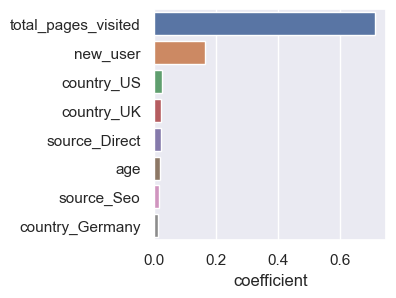

In [151]:
fig, ax= plt.subplots(figsize=(3,3))
sns.barplot(data=df_important_features, y=df_important_features.index, x="importance", 
            orient='h',ax=ax)
# ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('coefficient')
plt.show()

## 2.6. Conclusions and recommendations

**Conclusions:**

The feature importance calculation verify our speculations that the **a higher total number of pages a user has visited has a positive effect on the user conversion rate while marketing channeling sources have litte effect on the conversion rate**. 

We gained the additional information that **the importance of total number of pages visited outweights other user features by a large margin. This tells us the marketing team should highly target users who have visited more pages, as they are most likely to make purchases.**

Also, **younger users with existing accounts and from countries with high conversion rates should also be prioritized. Different choices of marketing channeling sources has little impact on the user conversion rate and should be considered irrelavent.**  

**Recommendations:**
1. The marketing team should highly prioritize users who have visited many pages but haven't made a purchase, e.g., sending them email advertisements/coupons.  
2. Younger users have higher conversion rates than old users. The marketing team should **expand their marketing channels to increases product/brand exposure to younger populaiton, e.g., advertisements on social platforms popular among young people**. Also, **investigate why the site is unpopular among older users, e.g., conduct surveys to identify the problems**. It could the that the UI is unfriendly, or the digital payment system is hard to navigate, etc. 
3. German users have the highest conversion rates but only 4.1% of the total users are German. The marketing team should **expand market channels in Germany to bring in more German users**; on the other hand Chinese users have extremely low conversion rate. Considering that around 1/4 of the users are from China, the low conversion rate doesn't make much sense. **There could critical issues with the Chinese site's UI (e.g., poor translation ), payment system, brand reputation, etc. If the issues are identified and fixed, this could be a massive opportunity seeing how large the Chinese market is**. 
4. Users with existing accounts have higher conversion rates compared to new users. Thus **users with accounts but have not converted could be targeted with advertising**. 



